# 0.Google Drive 연동
- Colab과 Google Drive를 연동시킵니다.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 1. Data Loading
- kaggle url로 부터 받은 Data를 pandas를 통해 Loading 합니다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
train = pd.read_csv("/content/gdrive/My Drive/Data Creator Camp 2020/A Round/Data/sentiment_dtm_train.csv", encoding = "CP949")
test = pd.read_csv("/content/gdrive/My Drive/Data Creator Camp 2020/A Round/Data/sentiment_dtm_test.csv", encoding = "CP949")

# 데이터 로딩하기

In [6]:
total = train.append(test, ignore_index = True)
total.shape
# train, Test 합치기

(18452, 302)

# 2. Exploratory Data Analysis
- 데이터의 Feature 확인과 함께 어떠한 값을 가지는지 확인
- 해당 데이터로 파악한 내용을 시각화 하여 논리적으로 맞는지 확인
- 그 밖에 본인의 Insight를 가지고 시각화 해 봅시다.

In [9]:
# 논리적인 값 확인하기

X = total.drop(columns = ['Id', 'label'])

np.unique(X)

# Id와 label을 제외한 모든 Feature에서 0과 1값만 갖는 Binary data라는 것을 확인합니다.
# 이를 Binary Term Dcoumnet Matrix라고 합니다.

array([0, 1])

## 2.1 Dcoument EDA
- 각 row는 Document를 뜻하게 됩니다.
- 이를 통해 Document가 몇개의 word를 갖고 있는지 파악하여 시각화 해봅시다.

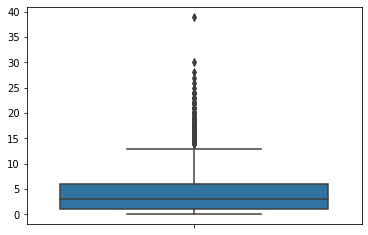

In [10]:
# Document의 Token 갯수의 Distibution 확인
sns.boxplot(y = X.sum(axis = 1))

In [11]:
# Document의 Token 갯수의 요약통계량 확인
X.sum(axis = 1).describe()

count    18452.000000
mean         4.120962
std          3.583243
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         39.000000
dtype: float64

## 2.2 Word EDA
- 각 column은 Word를 뜻하게 됩니다.
- 이를 통해 각 Word가 몇번씩 등장하고 긍부정에서는 어떤 Word가 많이 등장하는지 확인해봅시다.

In [12]:
# 가장 많이 등장한 Token 30개 확인
pd.DataFrame(X.sum(axis = 0)).sort_values(0, ascending=False).iloc[:30]

,0
정말,2316
너무,2007
진짜,1754
맛있어요,1211
여기,1140
다,1011
맛도,994
완전,915
그냥,806
또,798


In [13]:
label0_X = total.query('label == 0').drop(columns = ['Id', 'label'])
label1_X = total.query('label == 1').drop(columns = ['Id', 'label'])

# label 0과 1을 나눠 Id와 label columns을 드랍하여 각각 변수로 저장합니다.

In [14]:
# 부정에서 가장 많이 등장한 Token 30개 확인
pd.DataFrame(label0_X.sum(axis = 0)).sort_values(0, ascending=False).iloc[:30]

,0
진짜,475
정말,469
너무,376
그냥,335
다,288
여기,257
좀,205
완전,194
서비스,189
맛도,182


In [15]:
# 긍정에서 가장 많이 등장한 Token 30개 확인
pd.DataFrame(label1_X.sum(axis = 0)).sort_values(0, ascending=False).iloc[:30]

,0
정말,718
너무,645
맛있어요,604
진짜,453
맛도,335
여기,331
또,320
맛있게,293
맛있고,290
사장님,268


## 2.3 Label Distribution 확인하기
- 각각의 긍부정이 몇대 몇인지 확인해봅시다.

In [16]:
train['label'].value_counts()

1    5402
0    4050
Name: label, dtype: int64

In [17]:
train['label'].value_counts('percentage')

1    0.571519
0    0.428481
Name: label, dtype: float64

# 3. Modeling : Classification
- Logistic Regression
- KNN
- 각각의 Hyperparaparameter를 튜닝시켜 가장 좋은 성능 모델로 Test를 진행하여 체점을 진행해보겠습니다.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [19]:
# train 데이터의 X와 y를 split시킵니다.
X = train.drop(columns = ['Id','label'])
y = train['label']

X.shape, y.shape

((9452, 300), (9452,))

# 3.2 Hyper-parameter Searching
- Grid Search 방법을 진행합니다. (설정한 모든 경우의 조합으로 성능을 평가함.)
- 이를 5-Fold Cross Validation을 통해 가장 좋았던 파라미터를 찾습니다.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [21]:
algorithmes = [LogisticRegression(), KNeighborsClassifier(n_jobs=-1)]

In [22]:
##실험 파라미터 셋팅###
params = []
params.append([{
    "solver" : ["saga"],
    "penalty" : ["l1"],
    "C" : [0.1,  5.0, 7.0, 10.0, 15.0, 20.0, 100.0]
    },{
    "solver" : ['liblinear'],
    "penalty" : ["l2"],
    "C" : [0.1,  5.0, 7.0, 10.0, 15.0, 20.0, 100.0]
    }
    ]) #Logistic Regression 하이퍼 파라미터

params.append({
    "p":[int(i) for i in range(1,3)],
    "n_neighbors":[i for i in range(2, 5)]}) #KNN 하이퍼 파라미터


In [23]:
#### 5 - Fold Cross Validation & Accuracy
scoring = ['accuracy']
estimator_results = []
for i, (estimator, params) in enumerate(zip(algorithmes,params)):
    gs_estimator = GridSearchCV(
            refit="accuracy", estimator=estimator,param_grid=params, scoring=scoring, cv=5, verbose=1, n_jobs=4)
    print(gs_estimator)

    gs_estimator.fit(X, y)
    estimator_results.append(gs_estimator)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid=[{'C': [0.1, 5.0, 7.0, 10.0, 15.0, 20.0, 100.0],
                          'penalty': ['l1'], 'solver': ['saga']},
                         {'C': [0.1, 5.0, 7.0, 10.0, 15.0, 20.0, 100.0],
                          'penalty': ['l2'], 'solver': ['liblinear']}],
             pre_dispatch='2*n_jobs', refit='accuracy',
             re

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=4,
             param_grid={'n_neighbors': [2, 3, 4], 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit='accuracy',
             return_train_score=False, scoring=['accuracy'], verbose=1)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  2.8min finished


In [24]:
print("Logistic의 가장 좋은 성능은 ",estimator_results[0].best_score_)
print("KNN의 가장 좋은 성능은 ",estimator_results[1].best_score_)

Logistic의 가장 좋은 성능은  0.7896731664050542
KNN의 가장 좋은 성능은  0.6977328979655791


In [25]:
# Logistic를 통한 가장 좋은 Feature 확인
 
# estimator_results[0].best_estimator_.coef_
feature_name = X.columns.to_numpy()

print("Coefficient가 가장 큰 30개의 Feature 확인")
feature_name[estimator_results[0].best_estimator_.coef_.argsort()[::-1]][:30]

Coefficient가 가장 큰 30개의 Feature 확인


array([['다신', '다시는', '불친절', '불친절하고', '그냥', '없고', '차라리', '아깝다', '최악',
        '없음', '손님', '가지마세요', '아줌마', '절대', '비추', '왜', '무슨', '별', '아니고',
        '싸가지', '아까움', '그렇게', '서비스', '시켰는데', '이건', '돈', '기분', '전화를',
        '어떻게', '제대로', '손님이', '참', '서비스는', '아', '없네요', '그럼', '했더니', '전화',
        '다시', '하나도', '걍', '사람이', '장사', '서비스가', '얼마나', '이제', '맛은', '하고',
        '별로', '사람', '지금', '반찬', '없어요', '뭐', '없는', '보고', '하니', '거의', '주고',
        '있는데', '다', '계속', '직원들', '했는데', '먼저', '원래', '내가', '먹는', '진심',
        '않고', '내', '그', '음식을', '솔직히', '기분이', '갔는데', '식당', '서비스도', '주문',
        '미리', '진짜', '그런', '하나', '좀', '비해', '하면', '하지만', '같은', '그래서',
        '집에서', '그래도', '글', '하는데', '이렇게', '때문에', '나오고', '안', '이', '말',
        '가격은', '아니라', '없이', '아주머니', '평가', '없어서', '싶네요', '가서', '밥', '갔다가',
        '배달', '시켜', '고기가', '매우', '바로', '하네요', '곳', '처음', '할', '와', '앞으로',
        '양이', '것', '음식이', '전에', '가고', '이런', '나와서', '한', '배달이', '다른',
        '고기', '가격', '먹는데', '제', '오늘', '그리고', '시켜먹었는데', '여긴', '더', '너무',
   

# 3.3 Final Model Training
- 가장 좋은 Model과 Hyperparameter를 통해 Train set 전체를 학습시켜 최종적인 Test set을 예측합니다.


In [26]:
final_model = estimator_results[0].best_estimator_
final_model.fit(X, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

# 3.4 Test 예측하기
- Id, label로 구성된 dataframe을 만들어 제출합니다.



In [27]:
X_test = test.drop(columns='Id')

In [28]:
y_pred = final_model.predict(X_test)

In [29]:
# 제출 파일 만들기
submission_df = pd.DataFrame()
submission_df['Id'] = test['Id'] #ID
submission_df['label'] = y_pred #예측값

In [30]:
submission_df.to_csv("submission_result.csv",index=False, encoding = 'utf8')

In [ ]:
# 데이터 저장 경로는 왼쪽에서 확인 가능하며 /content/에 저장돼 있습니다.
# 해당 방법과 같이 파일을 로컬로 다운로드하시고 제출하시면 됩니다.

100% 69.8k/69.8k [00:00<00:00, 279kB/s]
403 - Your team has used its submission allowance (5 of 5). This resets at midnight UTC (16 hours from now).
